# Autoencoder: Image denoising

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [2]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=True, transform=transform)
validset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=False, transform=transform)

batch_size = 20

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

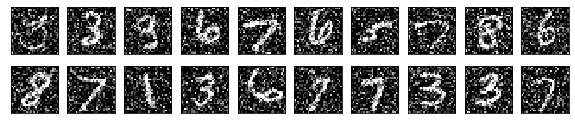

In [3]:
images, labels = next(iter(trainloader))
noise = torch.from_numpy(np.random.normal(0,0.4,tuple(images.shape)) ).float()
noisy_images = np.clip(images + noise, 0.0,1.0)

fig, ax = plt.subplots(2,10, figsize=(10,2))
for i in range(batch_size):
    row = i // 10
    col = i % 10
    ax[row, col].imshow(noisy_images[i,0,:,:], cmap='gray')
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)
plt.show()

### Model

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## Encoder ##
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=3, stride=1, padding=1)
        
        ## Pooling ##
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Decoder ##
        self.t_conv3 = nn.ConvTranspose2d(4, 128, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)
                
    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
                
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv1(x))
        
        return x

model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv3): ConvTranspose2d(4, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv1): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
)


### Loss function and optimizer

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 20
for iepoch in range(n_epochs):
    batch_loss = 0
    for ibatch, (images, labels) in enumerate(trainloader):
        # Display progress
        progress = (ibatch+1) / len(trainloader) * 100
        sys.stdout.write('\rEpoch: {}/{} ... Progress: {:0.2f}% ... '.format(iepoch+1, n_epochs, progress))
        sys.stdout.flush()
        
        ## Noisy images
        noise = torch.from_numpy(np.random.normal(0,0.4,tuple(images.shape)) ).float()
        noisy_images = np.clip(images + noise, 0.0, 1.0)
        ## Send images and noisy images to GPU/CPU
        images = images.to(device)
        noisy_images = noisy_images.to(device)
        
        ## Forward pass
        output = model(noisy_images)
        loss = criterion(output, images)
        ## Backward and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ## Loss
        batch_loss += loss.item() * images.shape[0]
    epoch_loss = batch_loss / len(trainloader)
    print('Train loss: {:0.6f}'.format(epoch_loss))

Epoch: 1/20 ... Progress: 100.00% ... Train loss: 0.755870
Epoch: 2/20 ... Progress: 100.00% ... Train loss: 0.532427
Epoch: 3/20 ... Progress: 100.00% ... Train loss: 0.491064
Epoch: 4/20 ... Progress: 100.00% ... Train loss: 0.469324
Epoch: 5/20 ... Progress: 100.00% ... Train loss: 0.455994
Epoch: 6/20 ... Progress: 100.00% ... Train loss: 0.446284
Epoch: 7/20 ... Progress: 100.00% ... Train loss: 0.438611
Epoch: 8/20 ... Progress: 100.00% ... Train loss: 0.432415
Epoch: 9/20 ... Progress: 100.00% ... Train loss: 0.427774
Epoch: 10/20 ... Progress: 100.00% ... Train loss: 0.423674
Epoch: 11/20 ... Progress: 100.00% ... Train loss: 0.420005
Epoch: 12/20 ... Progress: 100.00% ... Train loss: 0.416845
Epoch: 13/20 ... Progress: 100.00% ... Train loss: 0.412949
Epoch: 14/20 ... Progress: 100.00% ... Train loss: 0.410666
Epoch: 15/20 ... Progress: 100.00% ... Train loss: 0.407712
Epoch: 16/20 ... Progress: 100.00% ... Train loss: 0.405399
Epoch: 17/20 ... Progress: 100.00% ... Train loss

### Visualize the performance

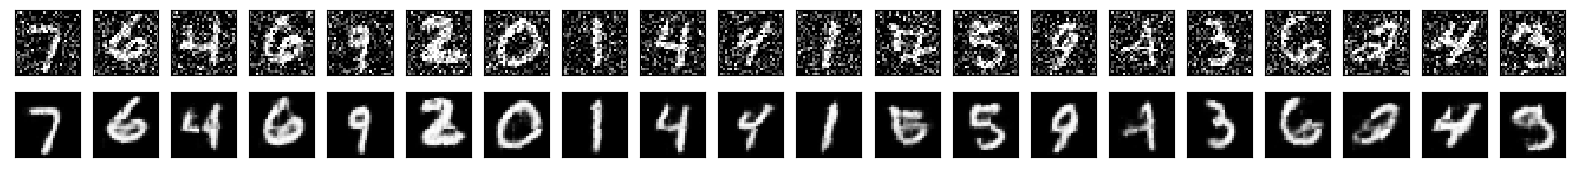

In [7]:
images, labels = next(iter(validloader))

noise = torch.from_numpy(np.random.normal(0,0.4,tuple(images.shape)) ).float()
noisy_images = np.clip(images + noise, 0.0,1.0)
noisy_images = noisy_images.to(device)

model.eval()
with torch.no_grad():
    output = model(noisy_images)
output = output.view(output.shape[0], 1, 28, 28)

noisy_images = noisy_images.to('cpu').numpy()
output = output.to('cpu').numpy()

fig, ax = plt.subplots(2,images.shape[0], figsize=(images.shape[0],2), dpi=100, sharex=True, sharey=True)
for i in range(output.shape[0]):
    ax[0,i].imshow(noisy_images[i,0,:,:], cmap='gray')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    ax[1,i].imshow(output[i,0,:,:], cmap='gray')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
plt.show()